# CNN Cancer Detection Project

Recurrent Neural Networks (RNN) are good at processing sequence data for predictions. Therefore, they are extremely useful for deep learning applications like speech recognition, speech synthesis, natural language understanding, etc.

Three are three main types of RNNs: SimpleRNN, Long-Short Term Memories (LSTM), and Gated Recurrent Units (GRU).

In this project, I will create an algorithm using GRU to diferentiate tweets communicating emergeny situations to non-urgent tweets. I will start with EDA, then split the data in train and test samples, define the GRU model, fit it and test its accuracy.  

We will be using the data available at https://www.kaggle.com/competitions/nlp-getting-started/data

In [193]:
# import necessary libraries
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, SimpleRNN, Activation, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, Flatten, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import spacy
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2
import gc
import os

# Exploratory Data Analysis

In this section, we will analyse the data in order to prepare it for use in the model.

By showing a couple values of the 'train.csv' file, we can see that it is composed of an Id, a keyword that can be NaN, a location that can be NaN, the main text of the tweet and its binary target classified as emergency (1) or non-emergency (0). This is also called the sentiment.

In [194]:
data = pd.read_csv("data/train.csv", header=0, encoding='latin-1')
print("The shape of the original dataset is {}".format(data.shape))
data.head()

The shape of the original dataset is (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [196]:
data['location'].value_counts()[:10]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: location, dtype: int64

### EDA Functions

Before we start data preparation, we first define some useful functions:

- <span style="color: red;">load_glove_model</span> loads the twitter embeddings model that can be downloaded here : https://www.kaggle.com/datasets/fullmetal26/glovetwitter27b100dtxt. This model is trained on 2 billion tweets, which contains 27 billion tokens and 1.2 million vocabs.
- <span style="color: red;">remove_stopwords</span> removes the stop words in a sentence
- <span style="color: red;">lemmatize</span> performs lemmatization (grouping together the different inflected forms of a word so they can be analyzed as a single item) on a sentence
- <span style="color: red;">sent_vectorizer</span> converts a sentence into a vector using the glove_model. This function may be used if we want a different type of input to the RNNs.

In [197]:
def load_glove_model(glove_file):
    print("[INFO]Loading GloVe Model...")
    model = {}
    with open(glove_file, 'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embeddings = [float(val) for val in split_line[1:]]
            model[word] = embeddings
    print("[INFO] Done...{} words loaded!".format(len(model)))
    return model
# adopted from utils.py
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(sentence):
    '''
    function to remove stopwords
        input: sentence - string of sentence
    '''
    new = []
    # tokenize sentence
    sentence = nlp(sentence)
    for tk in sentence:
        if (tk.is_stop == False) & (tk.pos_ !="PUNCT"):
            new.append(tk.string.strip())
    # convert back to sentence string
    c = " ".join(str(x) for x in new)
    return c


def lemmatize(sentence):
    '''
    function to do lemmatization
        input: sentence - string of sentence
    '''
    sentence = nlp(sentence)
    s = ""
    for w in sentence:
        s +=" "+w.lemma_
    return nlp(s)

def sent_vectorizer(sent, model):
    '''
    sentence vectorizer using the pretrained glove model
    '''
    sent_vector = np.zeros(200)
    num_w = 0
    for w in sent.split():
        try:
            # add up all token vectors to a sent_vector
            sent_vector = np.add(sent_vector, model[str(w)])
            num_w += 1
        except:
            pass
    return sent_vector

This cell allows to drop any duplicate of tweets. After checking, the dataframe is smaller which confirms there were duplicates.

In [199]:
data = data.drop_duplicates(subset=['text'], keep=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7378 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


### Isolating useful data

To train the model, we only need the tweet's main text which is the text column and the tweet sentiment information which is the 'target column. We will store the tweet text in data_X and the sentiment in data_y.


In [201]:
data_X = data['text'].to_numpy()
data_y = data['target']
data_y = pd.get_dummies(data_y).to_numpy()
data_X[:3]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"],
      dtype=object)

The following code converts the tweet text to sequence format that can be used in the GRU model.

In [ ]:
# load the glove model
glove_model = load_glove_model("data/glove.twitter.27B.200d.txt")

In [202]:
# number of vocab to keep
max_vocab = 18000
# length of sequence that will generate
max_len = 15

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(data_X)
sequences = tokenizer.texts_to_sequences(data_X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_keras = pad_sequences(sequences, maxlen=max_len, padding="post")

Found 22585 unique tokens.


We now split data into training and validation sets.

In [204]:
train_X, valid_X, train_y, valid_y = train_test_split(data_keras, data_y, test_size = 0.3)

We can now obtain the word embedding matrix using the GloVe model.

In [205]:
# calculate number of words
nb_words = len(tokenizer.word_index) + 1

# obtain the word embedding matrix
embedding_matrix = np.zeros((nb_words, 200))
for word, i in word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 10115


# Model building and fitting

In this section, we will create the model and fit it to the training data. We will then predict if a tweet represents an emergency or not and compare those results to the testing data.

### Model building

To build the model, I have chosen the following architecture : input (embedding matrix) --> GRU Model --> Output with sigmoid activation.

In [206]:
model = Sequential()
# add an embedding layer

model.add(Embedding(nb_words, 
                200, 
                weights=[embedding_matrix], 
                input_length= max_len,
                trainable = False))

# add an RNN layer according to rnn_model
model.add(GRU(200))
#model.add(Dense(500,activation='relu'))
#model.add(Dense(500, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
            optimizer='adam',
            metrics=['accuracy'])

In [207]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 15, 200)           4517200   
_________________________________________________________________
gru_10 (GRU)                 (None, 200)               241200    
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 402       
Total params: 4,758,802
Trainable params: 241,602
Non-trainable params: 4,517,200
_________________________________________________________________


we use adaptive moment estimation (Adam) with a learning rate of 0.0005 for optimizing the model which essentially mimics momentum for gradient and gradient-squared.

In [208]:
adam_optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer = adam_optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

#### Callbacks
Callbacks are used to check whether the model is improving with each epoch or not. If not, ReduceLROnPlateau allows to decrease the learning rate further. If the model performance is still not improving, then training will be stopped by EarlyStopping. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [209]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=4,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [210]:
history = model.fit(train_X, train_y,
                    validation_data=(valid_X, valid_y),
                    batch_size=120,
                    epochs = 20,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/20
44/44 [==============================] - 6s 83ms/step - loss: 0.6078 - accuracy: 0.6775 - val_loss: 0.4811 - val_accuracy: 0.7835
Epoch 2/20
44/44 [==============================] - 3s 78ms/step - loss: 0.4536 - accuracy: 0.7949 - val_loss: 0.4816 - val_accuracy: 0.7763
Epoch 3/20
44/44 [==============================] - 3s 75ms/step - loss: 0.4341 - accuracy: 0.7982 - val_loss: 0.4590 - val_accuracy: 0.7907
Epoch 4/20
44/44 [==============================] - 3s 75ms/step - loss: 0.4215 - accuracy: 0.8101 - val_loss: 0.4487 - val_accuracy: 0.8028
Epoch 5/20
44/44 [==============================] - 3s 75ms/step - loss: 0.4072 - accuracy: 0.8188 - val_loss: 0.4430 - val_accuracy: 0.8055
Epoch 6/20
44/44 [==============================] - 3s 76ms/step - loss: 0.3950 - accuracy: 0.8259 - val_loss: 0.4469 - val_accuracy: 0.8082
Epoch 7/20
44/44 [==============================] - 4s 81ms/step - loss: 0.3838 - accuracy: 0.8276 - val_loss: 0.4544 - val_accuracy: 0.8005

Epoch 00007:

We can see that the EarlyStopping function kicks in quite fast as the validation accuracy is very high from the start and doesn't change much for each epoch. Even reducing the learning rate during the model fitting barely improves the results.  

We can visualize the evolution of loss and accuracy for each epoch and how the model performs with the split testing data. It stays fair to its 80% accuracy.

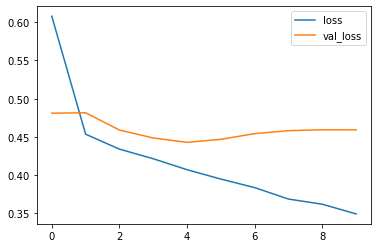

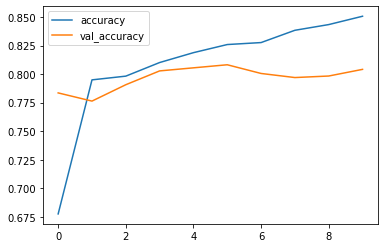

In [211]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [212]:
predictions = model.predict(valid_X)
predictions = predictions.argmax(axis=1)
print(classification_report(valid_y.argmax(axis=1), predictions))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1286
           1       0.85      0.67      0.75       945

    accuracy                           0.81      2231
   macro avg       0.82      0.79      0.80      2231
weighted avg       0.81      0.81      0.80      2231



## Testing the model with the submission test sample
Now that we have a trained model, we can test it on the unseen test data images. We must also normalize the test data like we did with the training data. Then we run the model to find its predictions, save it and upload it to kaggle. (Update : after Kaggle submission, my model has a 0.60 accuracy score).

In [215]:
df = pd.read_csv("data/test.csv", header=0, encoding='latin-1')
print("The shape of the testing dataset is {}".format(data.shape))
df.tail()

The shape of the testing dataset is (7434, 5)


,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [216]:
# isolate the tweet texts
test_X = df['text'].to_numpy()

max_vocab = 18000
# length of sequence that will generate
max_len = 15

# prepare data for embedding
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(test_X)
sequences = tokenizer.texts_to_sequences(test_X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_keras1 = pad_sequences(sequences, maxlen=max_len, padding="post")
data_keras1

Found 12818 unique tokens.


array([[  34,  567,    5, ...,    0,    0,    0],
       [ 272,   53,  247, ...,    0,    0,    0],
       [  42,   22,  891, ...,  481,  101,   43],
       ...,
       [ 714,  299,  732, ...,    0,    0,    0],
       [3758,  697,  469, ...,    0,    0,    0],
       [3412,   58, 3419, ...,    0,    0,    0]], dtype=int32)

In [217]:
prediction = model.predict(data_keras1, verbose=1)
len(prediction.argmax(axis=1))

102/102 [==============================] - 1s 9ms/step


3263

In [218]:
predictions = np.transpose(prediction)[0]
submission_df = pd.DataFrame(df['id'])
submission_df.insert(1, "target", prediction.argmax(axis=1), True)
submission_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [219]:
submission_df.to_csv('submission1.csv', index=False)

## Conclusion
Through this project, I designed a GRU model capable of sentiment analysis to separate emergency tweets from non-emergency tweets. Using the pre-trained word embeddings from the glove.twitter.27B.200d.txt data as weights for the Embedding layer lead to better results and faster convergence. My model achieved a 0.6 accuracy with the Kaggle test data which is rather low.  
I could attempt to improve it by going deeper in EDA analysis so that each tweet is easier to understand by the model. This model could also be improved by training it with a larger database. I acheived 80% on validation accuracy with the training set but it wasn't representative enough to acheive the same accuracy with the test set.

### References
[1] https://haochen23.github.io/2020/01/nlp-rnn-sentiment.html#.YydOOOzMI1I  
[2] https://www.kaggle.com/code/astraz93/beginner-tf-idf-svc-score-80-5